
# Análisis de Evasión de Clientes (Churn) – Telecom X



Este notebook contiene el desarrollo completo del desafío de churn para **Telecom X**. La idea es trabajar los datos desde cero: cargar el JSON con la información de clientes, comprender la estructura, limpiarla, transformarla y luego explorarla con gráficos y estadísticas. Al final, obtendremos insights y recomendaciones para reducir la evasión.

Los datos se proporcionan en un archivo `TelecomX_Data.json`. Si trabajas en un entorno con acceso a internet, podrías cargarlos desde la API original, pero aquí preferimos usar el archivo local para que el análisis sea reproducible sin depender de la conexión.



## Objetivos

- Importar los datos desde un archivo JSON y convertirlos en un DataFrame manejable.
- Comprender la estructura del dataset y los tipos de variables disponibles.
- Realizar una limpieza básica: tratar valores faltantes y datos inconsistentes.
- Crear nuevas variables útiles para el análisis (por ejemplo, la cuenta diaria).
- Hacer un análisis exploratorio de datos (EDA) que incluya métricas descriptivas y visualizaciones.
- Extraer conclusiones y sugerir acciones que puedan ayudar a Telecom X a retener más clientes.


In [11]:

import pandas as pd
import json
import matplotlib.pyplot as plt

# Configuración para evitar avisos de compatibilidad
pd.options.display.float_format = '{:.2f}'.format



## 1. Cargar los datos

Primero vamos a abrir el archivo JSON que contiene la información de los clientes. El JSON está estructurado por secciones (cliente, teléfono, internet y cuenta). Vamos a leerlo y luego combinaremos sus partes en un único DataFrame.



### 1.1 Estructura del JSON

Cada registro tiene las claves principales `customerID` y `Churn` además de cuatro subdiccionarios: `customer`, `phone`, `internet` y `account`. La idea es combinar todas esas secciones en un único diccionario por cliente para crear nuestro DataFrame.


In [12]:
import json
import requests

# Podemos usar el archivo de forma local, pero en este caso contrario lo usaremos desde la URL.
json_path = 'TelecomX_Data.json'
try:
    with open(json_path, 'r', encoding='utf-8') as f:
        raw_data = json.load(f)
except FileNotFoundError:
    url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json'
    raw_data = requests.get(url).json()

# Visualizar las claves del primer registro para comprender la estructura
raw_data[0].keys()


dict_keys(['customerID', 'Churn', 'customer', 'phone', 'internet', 'account'])

In [13]:

# Aplanar el JSON y crear un DataFrame
rows = []
for item in raw_data:
    row = {}
    # ID y variable objetivo
    row['customerID'] = item['customerID']
    row['Churn'] = item['Churn'] if item['Churn'] != '' else None

    # Datos demográficos y de cliente
    row.update(item['customer'])

    # Datos de telefonía
    row.update(item['phone'])

    # Datos de internet
    row.update(item['internet'])

    # Datos de cuenta
    acc = item['account']
    row['Contract'] = acc['Contract']
    row['PaperlessBilling'] = acc['PaperlessBilling']
    row['PaymentMethod'] = acc['PaymentMethod']
    row['MonthlyCharges'] = acc['Charges']['Monthly']
    # Convertir Total a numérico; si está vacío, se asignará None
    total = acc['Charges']['Total']
    try:
        row['TotalCharges'] = float(total)
    except:
        row['TotalCharges'] = None
    rows.append(row)

# Crear DataFrame
telecom_df = pd.DataFrame(rows)

# Mostrar las primeras filas	elecom_df.head()



## 2. Exploración inicial

Ahora que tenemos el DataFrame, revisaremos sus columnas, tipos de datos y la presencia de valores nulos. Esto nos permite detectar problemas y planificar la limpieza.


In [14]:

# Mostrar información general del DataFrame
telecom_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7043 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contract          7267 non-null   object 


In [15]:

# Contar valores nulos por columna
telecom_df.isnull().sum()


,0
customerID,0
Churn,224
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0



### 2.1 Observaciones

- La variable `Churn` tiene varios valores nulos (vacíos), que representan clientes sin etiqueta de evasión. Para el análisis de churn, descartaremos estas filas.
- La columna `TotalCharges` tiene algunos nulos debido a campos vacíos o erróneos. Podemos rellenarlos con una medida estadística (media o mediana) o eliminarlos según convenga.
- El resto de columnas categóricas son de tipo `object` y las numéricas (`SeniorCitizen`, `tenure`, `MonthlyCharges`, `TotalCharges`) ya vienen en formato numérico.



## 3. Limpieza y preparación

En esta sección eliminamos los registros sin valor en `Churn`, convertimos la variable objetivo a formato binario y tratamos los valores faltantes en `TotalCharges`. También crearemos una columna nueva `Cuenta_Diaria` calculada como `MonthlyCharges / 30` para tener una visión más granular del gasto.


In [16]:

# Copiar el DataFrame para trabajar con él
clean_df = telecom_df.copy()

# Eliminar filas sin etiqueta de churn
clean_df = clean_df.dropna(subset=['Churn'])

# Convertir 'Churn' a variable binaria
clean_df['Churn_numeric'] = clean_df['Churn'].map({'Yes': 1, 'No': 0})

# Rellenar TotalCharges nulos con la mediana
clean_df['TotalCharges'] = clean_df['TotalCharges'].fillna(clean_df['TotalCharges'].median())

# Crear columna de cuenta diaria
clean_df['Cuenta_Diaria'] = clean_df['MonthlyCharges'] / 30

# Revisar que ya no queden nulos
clean_df.isnull().sum()


,0
customerID,0
Churn,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0



## 4. Análisis descriptivo

Revisaremos estadísticas básicas de las variables numéricas para entender sus distribuciones y posibles outliers. Esto incluye `tenure`, `MonthlyCharges`, `TotalCharges` y la nueva columna `Cuenta_Diaria`.


In [17]:

# Estadísticas descriptivas de variables numéricas
clean_df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Cuenta_Diaria']].describe()


,tenure,MonthlyCharges,TotalCharges,Cuenta_Diaria
count,7043.00,7043.00,7043.00,7043.00
mean,32.37,64.76,2281.92,2.16
std,24.56,30.09,2265.27,1.00
min,0.00,18.25,18.80,0.61
25%,9.00,35.50,402.23,1.18
50%,29.00,70.35,1397.47,2.34
75%,55.00,89.85,3786.60,2.99
max,72.00,118.75,8684.80,3.96



## 5. Distribución de evasión

Empecemos viendo cuántos clientes han cancelado (`Churn = Yes`) frente a los que siguen activos (`Churn = No`). Esto nos dará una idea del balance del dataset.


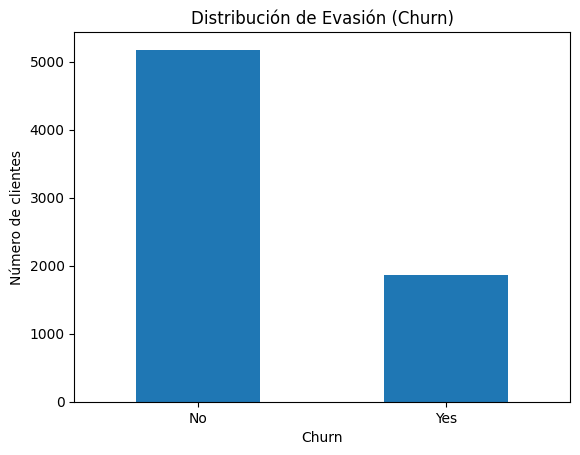

In [18]:

# Distribución de churn
clean_df['Churn'].value_counts().plot(kind='bar')
plt.title('Distribución de Evasión (Churn)')
plt.xlabel('Churn')
plt.ylabel('Número de clientes')
plt.xticks(rotation=0)
plt.show()



## 6. Churn por variables categóricas

A continuación analizaremos cómo se distribuye el churn según algunas variables categóricas. Utilizaremos tablas de frecuencia y gráficos de barras para visualizar las diferencias.

### 6.1 Churn por tipo de contrato


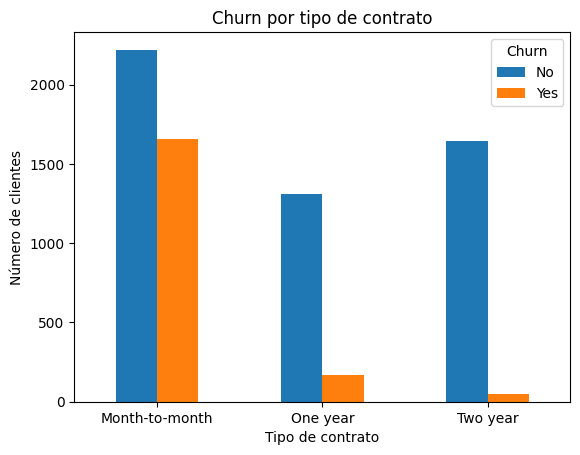

In [19]:

# Churn por tipo de contrato
contract_crosstab = pd.crosstab(clean_df['Contract'], clean_df['Churn'])
contract_crosstab.plot(kind='bar')
plt.title('Churn por tipo de contrato')
plt.xlabel('Tipo de contrato')
plt.ylabel('Número de clientes')
plt.xticks(rotation=0)
plt.show()



### 6.2 Churn por método de pago


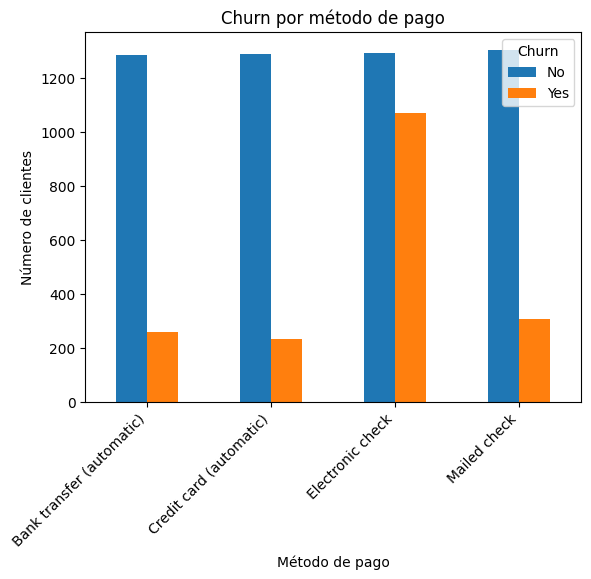

In [20]:

# Churn por método de pago
pay_crosstab = pd.crosstab(clean_df['PaymentMethod'], clean_df['Churn'])
pay_crosstab.plot(kind='bar')
plt.title('Churn por método de pago')
plt.xlabel('Método de pago')
plt.ylabel('Número de clientes')
plt.xticks(rotation=45, ha='right')
plt.show()



### 6.3 Churn por servicio de Internet


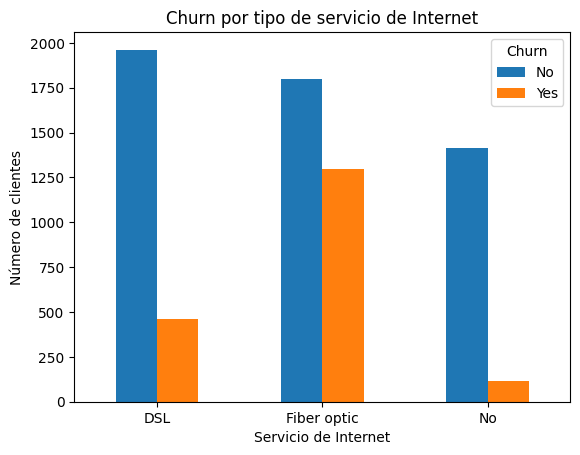

In [21]:

# Churn por tipo de servicio de Internet
internet_crosstab = pd.crosstab(clean_df['InternetService'], clean_df['Churn'])
internet_crosstab.plot(kind='bar')
plt.title('Churn por tipo de servicio de Internet')
plt.xlabel('Servicio de Internet')
plt.ylabel('Número de clientes')
plt.xticks(rotation=0)
plt.show()



## 7. Churn por variables numéricas

Veamos si hay diferencias en la distribución de algunas variables numéricas entre clientes que cancelaron y los que no. Usaremos gráficos de caja (boxplots) para comparar.

### 7.1 Tenure (tiempo de contrato)


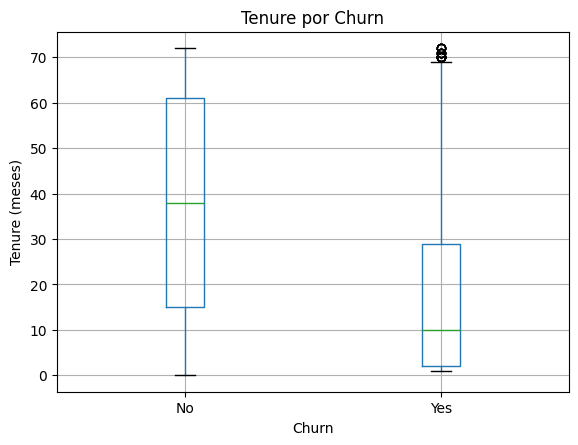

In [22]:

# Boxplot de tenure según churn
clean_df.boxplot(column='tenure', by='Churn')
plt.title('Tenure por Churn')
plt.suptitle('')  # Ocultar título automático
plt.xlabel('Churn')
plt.ylabel('Tenure (meses)')
plt.show()



### 7.2 Gastos mensuales


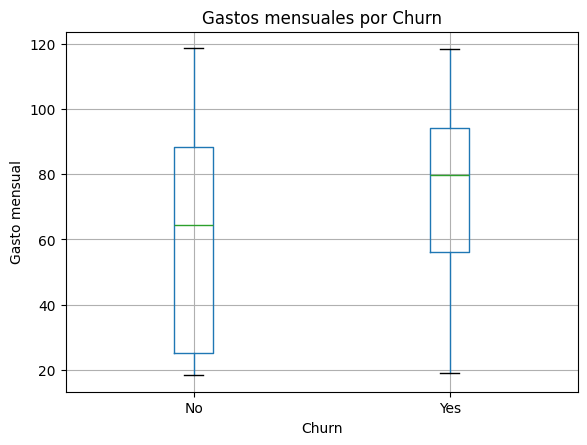

In [23]:

# Boxplot de MonthlyCharges según churn
clean_df.boxplot(column='MonthlyCharges', by='Churn')
plt.title('Gastos mensuales por Churn')
plt.suptitle('')
plt.xlabel('Churn')
plt.ylabel('Gasto mensual')
plt.show()



## 8. Análisis de correlación

Para entender mejor las relaciones entre variables numéricas y la evasión, calcularemos la matriz de correlación. Esto puede ayudar a identificar qué factores están más relacionados con el churn.


In [24]:

# Seleccionar variables numéricas relevantes
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Cuenta_Diaria', 'Churn_numeric']

corr_matrix = clean_df[num_cols].corr()

corr_matrix


,tenure,MonthlyCharges,TotalCharges,Cuenta_Diaria,Churn_numeric
tenure,1.00,0.25,0.83,0.25,-0.35
MonthlyCharges,0.25,1.00,0.65,1.00,0.19
TotalCharges,0.83,0.65,1.00,0.65,-0.20
Cuenta_Diaria,0.25,1.00,0.65,1.00,0.19
Churn_numeric,-0.35,0.19,-0.20,0.19,1.00



## 9. Conclusiones y recomendaciones

- **Distribución del churn:** En este conjunto de datos hay más clientes que se mantienen que clientes que cancelan. Esto significa que el dataset está algo desbalanceado, algo a tener en cuenta si se construyen modelos predictivos.

- **Tipo de contrato:** Los contratos de mes a mes tienen un porcentaje mucho más alto de cancelaciones en comparación con los contratos de uno o dos años. Esto sugiere que ofrecer incentivos para que los clientes migren a contratos más largos podría reducir la evasión.

- **Método de pago:** El método de pago tiene impacto: los clientes que utilizan cheque electrónico parecen cancelar más que quienes pagan con transferencia o tarjeta. Facilitar y promover métodos de pago automáticos podría ayudar a la retención.

- **Servicio de Internet:** Ciertos tipos de servicios (por ejemplo, conexiones sin internet o con DSL) tienen tasas de churn diferentes. Revisar la calidad de servicio y ofrecer mejoras a clientes con mayor riesgo puede ser efectivo.

- **Variables numéricas:** Los clientes con mayor `tenure` (más tiempo con la empresa) tienden a cancelar menos, mientras que los que gastan más al mes muestran una mayor variabilidad. Esto apunta a que la fidelización debería centrarse en los clientes nuevos y en quienes tienen facturaciones altas.

En resumen, el análisis exploratorio sugiere que hay varios factores asociados a la evasión, desde la forma de contrato hasta el método de pago y el tipo de servicio. Un siguiente paso natural sería entrenar un modelo de predicción para identificar en tiempo real a los clientes con mayor riesgo de cancelar y diseñar campañas personalizadas para retenerlos.
